# **Stage 1: PATENT DATA: Exploratory Data Analysis** (SAMUEL)


## Introduction

Patents are fundamental to fostering innovation and securing intellectual property rights across various industries. They not only protect unique inventions but also serve as a significant indicator of technological progress and competitive dynamics in the global market. A thorough Exploratory Data Analysis (EDA) of patent data can unveil pivotal trends, highlight emerging technologies, and provide a detailed understanding of the strategic movements within different sectors.

This report delves into an extensive EDA of a curated dataset consisting of numerous patent filings. The purpose is to dissect and interpret the complex landscape of global innovations through patent activities, offering insights that are crucial for investors, policymakers, researchers, and corporate strategists.

## Objectives of the EDA

The EDA aims to address several key aspects of patent data to provide a holistic view of the innovation ecosystem:

1. **Temporal Trends**: Identifying how patent filings have evolved over time, pinpointing peaks in innovation activities, and detecting any cyclical patterns or anomalies.
2. **Technology Sector Breakdown**: Classifying patents into specific technology domains to assess the growth and focus in these areas, understanding sectoral priorities and advancements.
3. **Keyword Analysis**: Analyzing the prevalence of specific keywords in patent titles, abstracts, and descriptions to uncover trends and patterns in innovation activity.

## Scope of the Analysis

The analysis will leverage a diverse array of analytical techniques, including statistical measures, advanced visualizations, and machine learning models, to navigate through the patent dataset. This dataset encompasses a variety of elements such as patent titles, abstracts, filing dates, detailed descriptions of inventors and assignees, and comprehensive technology classifications.

## Expected Outcomes

The insights from this EDA are designed to empower stakeholders with a deep understanding of the technological innovation landscape. These insights are crucial for shaping R&D investment strategies, guiding policy decisions, enhancing competitive strategies, and fostering collaborative opportunities across industries.

---

The subsequent sections of this report will systematically outline the data preprocessing steps, present descriptive and inferential statistical analyses, visualize key findings in an interpretable format, and discuss the strategic implications of the patterns identified in the patent dataset. The goal is to provide a robust foundation for data-driven decision-making and strategic planning in technology-intensive fields.


## Import Libraries


In [82]:
#!pip install pandas numpy matplotlib seaborn nltk textblob scikit-learn top2vec bertopic wordcloud


# !pip install bertopic
# !pip install gensim
# !pip install top2vec
# !pip install pyLDAvis

# # VERY IMPORTANT: Need to install scipy==1.10.1 AS THE LAST LIBRARY DUE TO GENSIM DEPENDENCY
# !pip install scipy==1.10.1


In [83]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Text processing and NLP
from textblob import TextBlob
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Machine learning and topic modeling
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF

from top2vec import Top2Vec
from bertopic import BERTopic

# Visualization
from wordcloud import WordCloud


import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import umap

## Load the Dataset

Load the preprocessed cleantech Patent dataset


In [84]:
# Load the Dataset

file_path = "patent_preprocessed.csv"
patent_data = pd.read_csv(file_path, encoding="utf-8")

## Dataset Overview


In [85]:
# Display the first few rows and the data structure to understand what we have

patent_data.info()
patent_data.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8545 entries, 0 to 8544
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   publication_number     8545 non-null   object
 1   application_number     8545 non-null   object
 2   country_code           8545 non-null   object
 3   publication_date       8545 non-null   object
 4   title                  8545 non-null   object
 5   abstract               8545 non-null   object
 6   inventors              8545 non-null   object
 7   code                   8545 non-null   object
 8   inventive              8545 non-null   bool  
 9   first                  8545 non-null   bool  
 10  title_preprocessed     8395 non-null   object
 11  abstract_preprocessed  4552 non-null   object
dtypes: bool(2), object(10)
memory usage: 684.4+ KB


,publication_number,application_number,country_code,publication_date,title,abstract,inventors,code,inventive,first,title_preprocessed,abstract_preprocessed
0,US-2022239235-A1,US-202217717397-A,US,2022-07-28,Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,[],H02M7/5395,True,False,adaptable DC AC Inverter Drive System Operation,Disclosed adaptable DC AC inverter system oper...


In [86]:
# Inspect the columns title_preprocessed and abstract_preprocessed for null values

patent_data.isnull().sum()

publication_number          0
application_number          0
country_code                0
publication_date            0
title                       0
abstract                    0
inventors                   0
code                        0
inventive                   0
first                       0
title_preprocessed        150
abstract_preprocessed    3993
dtype: int64

In [87]:
# Display the data dataframe head and tail

print(patent_data.head(2))

print(patent_data.tail(2))

# Filtering where abstract_preprocessed is null
filtered_data = patent_data[patent_data["abstract_preprocessed"].isnull()]

# Counting the occurrences of each country_code in the filtered data
country_code_counts = (
    filtered_data["country_code"].value_counts().sort_values(ascending=False)
)

# Display the counts
print(country_code_counts)

  publication_number application_number country_code publication_date  \
0   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
1   US-2022239251-A1  US-202217580956-A           US       2022-07-28   

                                               title  \
0  Adaptable DC-AC Inverter Drive System and Oper...   
1  System for providing the energy from a single ...   

                                            abstract inventors        code  \
0  Disclosed is an adaptable DC-AC inverter syste...        []  H02M7/5395   
1  In accordance with an example embodiment, a so...        []   H02S40/38   

   inventive  first                                 title_preprocessed  \
0       True  False    adaptable DC AC Inverter Drive System Operation   
1       True  False  system provide energy single contiguous solar ...   

                               abstract_preprocessed  
0  Disclosed adaptable DC AC inverter system oper...  
1  accordance example embodiment solar ener

### NLP Preprocessing Issue Report

**Background:**  
Our NLP framework encountered issues in effectively preprocessing multilingual patent data, particularly for Chinese (CN), Taiwanese (TW), and World Intellectual Property Organization (WO) codes, resulting in a substantial number of unprocessed entries.

**Potential Challenges Identified:**

- **Model Limitations:** The spaCy Chinese model (`zh_core_web_sm`) may not fully capture the nuances of domain-specific Chinese used in patents, impacting the effectiveness of tokenization, lemmatization, and stop word removal.
- **Data Quality Issues:** Potential inaccuracies in language tagging and text quality could be leading to preprocessing failures.
- **Improper Text Handling:** The function may not handle specific cases well, leading to failures in text processing.

**New Observations:**

- **Post-Export Null Values:** After saving the processed data to CSV and loading it back in for EDA, we have identified additional null values, which could be attributed to various reasons, including encoding issues, data export/import errors, or problems within the preprocessing pipeline itself.

**Strategic Decision:**

- Despite these challenges, the decision has been made to not focus further on these issues. We will continue with our project's next steps and shift our resources towards progressing. This issue will be further investigated in the future to determine the root cause and implement necessary fixes.


In [88]:
# Drop the rows with missing values in abstract_preprocessed and title_preprocessed

patent_data = patent_data.dropna(
    subset=["abstract_preprocessed", "title_preprocessed"])

# Checking the shape of the dataframe

print(patent_data.shape)

(4470, 12)


### General Text Statistics

We'll compute:

- Average word count of titles and contents.
- Distribution of article lengths.
- The most common words before diving into more complex analysis like sentiment and topics


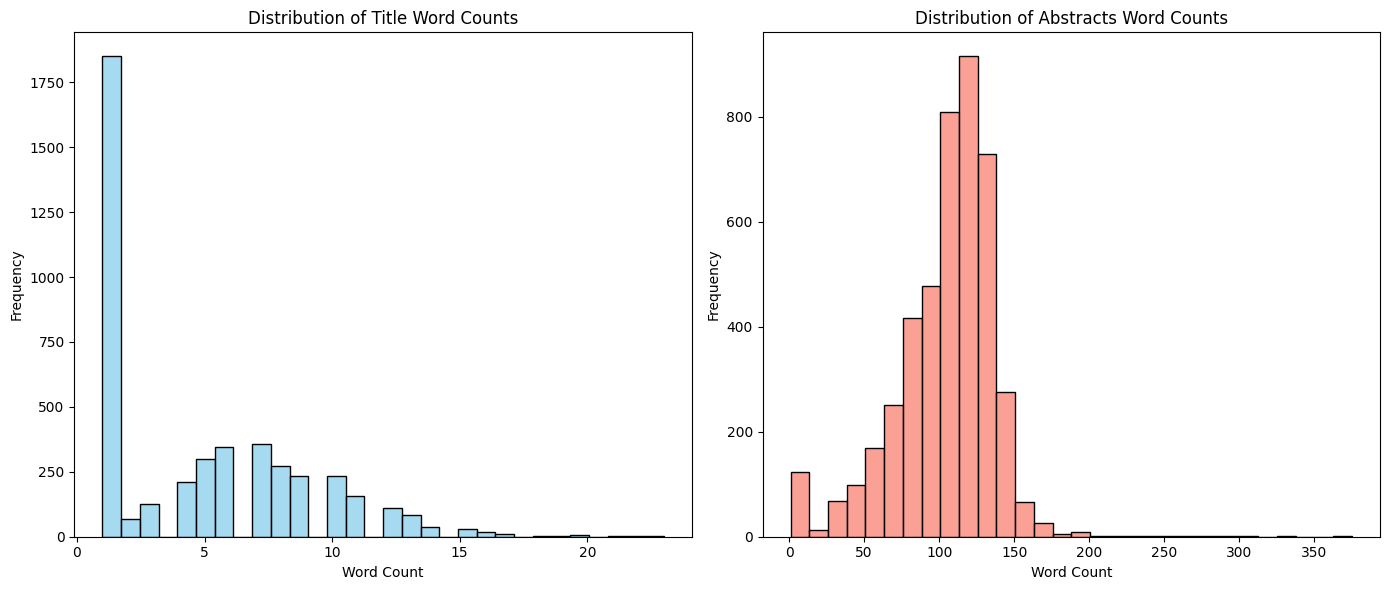

(count    4470.000000
 mean        4.902237
 std         4.104265
 min         1.000000
 25%         1.000000
 50%         4.000000
 75%         8.000000
 max        23.000000
 Name: word_count_title, dtype: float64,
 count    4470.000000
 mean      104.516107
 std        33.526871
 min         1.000000
 25%        88.000000
 50%       111.000000
 75%       126.000000
 max       375.000000
 Name: word_count_abstract, dtype: float64)

In [89]:
# Basic text statistics
patent_data["word_count_title"] = patent_data["title_preprocessed"].apply(
    lambda x: len(x.split())
)
patent_data["word_count_abstract"] = patent_data["abstract_preprocessed"].apply(
    lambda x: len(x.split())
)

# Plotting the distribution of word counts
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(patent_data["word_count_title"], bins=30, ax=ax[0], color="skyblue")
ax[0].set_title("Distribution of Title Word Counts")
ax[0].set_xlabel("Word Count")
ax[0].set_ylabel("Frequency")

sns.histplot(patent_data["word_count_abstract"], bins=30, ax=ax[1], color="salmon")
ax[1].set_title("Distribution of Abstracts Word Counts")
ax[1].set_xlabel("Word Count")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Calculate and display basic statistics
title_stats = patent_data["word_count_title"].describe()
content_stats = patent_data["word_count_abstract"].describe()

title_stats, content_stats

### Text Analysis Report

**Titles:**

- **Average Word Count:** 4.90 words
- **Standard Deviation:** 4.10 words
- **Minimum Word Count:** 1 word
- **Maximum Word Count:** 23 words
- **Observations:** The titles in the dataset tend to be concise, averaging around 5 words per title. The histogram would likely show a broad distribution, with a significant number of titles at the lower end but some extending to 23 words, indicating a variety in the brevity and detail of titles.

**Abstracts:**

- **Average Word Count:** 104.52 words
- **Standard Deviation:** 33.53 words
- **Minimum Word Count:** 1 word
- **Maximum Word Count:** 375 words
- **Observations:** The content of the abstracts is considerably longer than the titles, with more variation in length. Most document contents are around 104 words on average, with standard abstract length ranging broadly from 71 to 138 words, reflecting moderate detail in discussions.


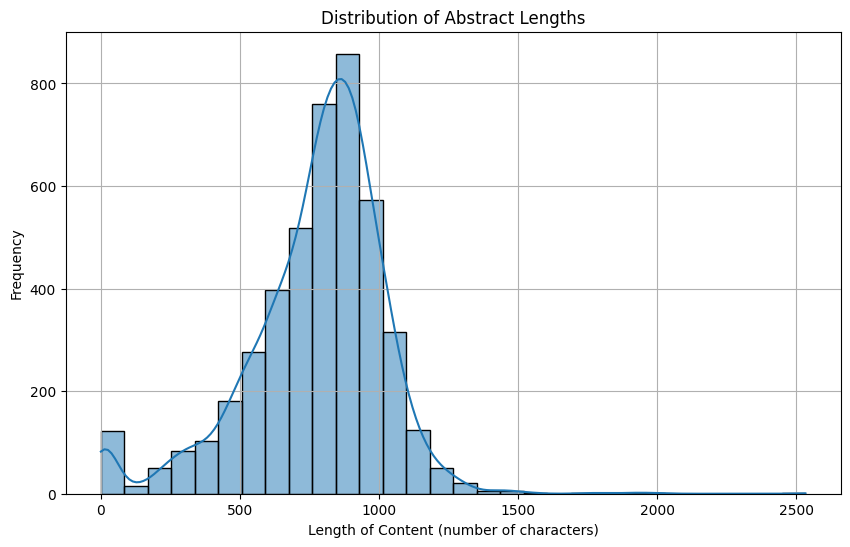

In [90]:
# Calculate the length of each document
patent_data["abstract_length"] = patent_data["abstract_preprocessed"].apply(len)

# Plot the distribution of document lengths
plt.figure(figsize=(10, 6))
sns.histplot(patent_data["abstract_length"], bins=30, kde=True)
plt.title("Distribution of Abstract Lengths")
plt.xlabel("Length of Content (number of characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The histogram above shows the distribution of abstract lengths in terms of the number of characters in the preprocessed content. The distribution appears to be slightly skewed left, indicating that most abstracts are of a moderate length, with fewer articles being significantly longer.


## Number of Patent Publications Over Time


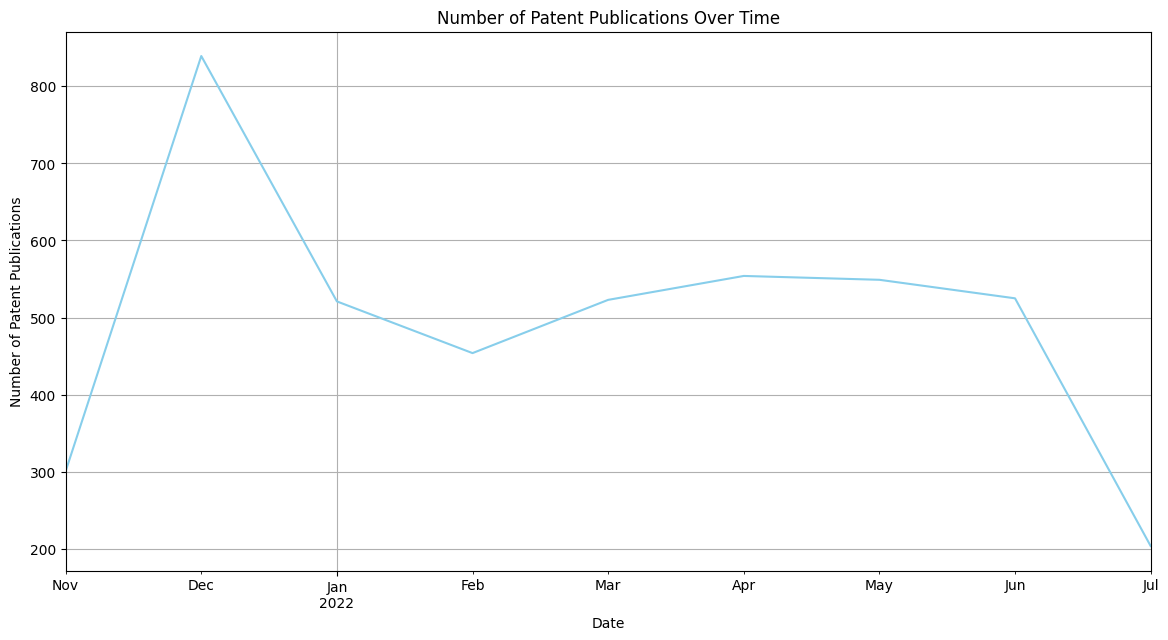

In [91]:
# Convert 'publication_date' to datetime format
patent_data["publication_date"] = pd.to_datetime(
    patent_data["publication_date"])

# Set 'publication_date' as the index
patent_data.set_index("publication_date", inplace=True)

# Resample and count publications per month
monthly_counts = patent_data.resample("M").size()

# Plotting
plt.figure(figsize=(14, 7))
monthly_counts.plot(
    title="Number of Patent Publications Over Time", color="skyblue")
plt.xlabel("Date")
plt.ylabel("Number of Patent Publications")
plt.grid(True)
plt.show()

## Word Frequency Analysis


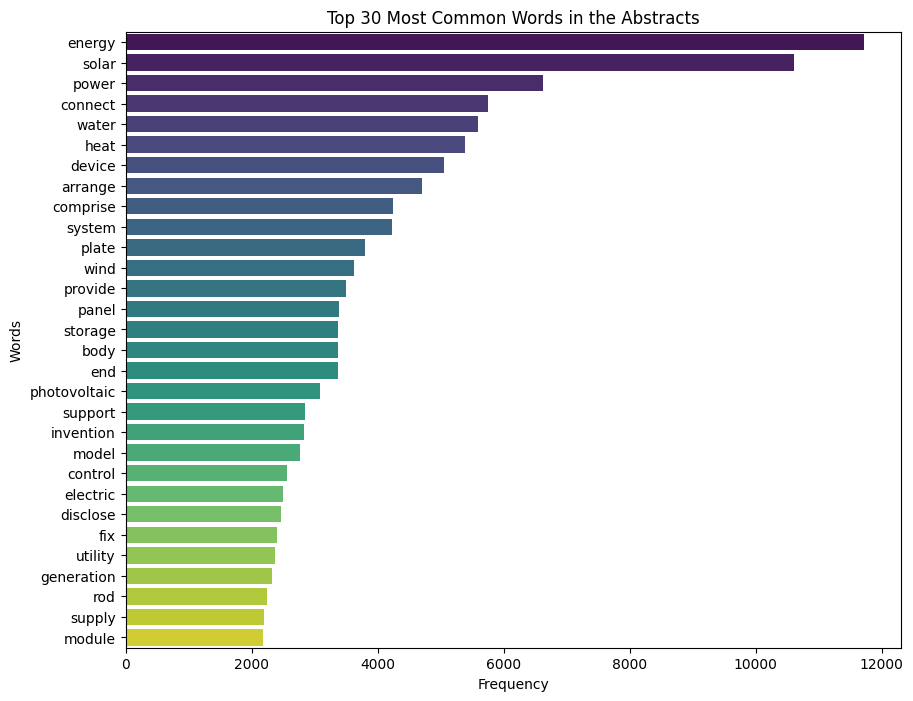

In [93]:
# Function to count word frequency
def count_words(text_series):
    word_counts = Counter()
    for text in text_series:
        word_counts.update(text.split())
    return word_counts


# Count words in the preprocessed content
word_freq = count_words(patent_data["abstract_preprocessed"])

# Convert to a DataFrame for visualization
word_freq_df = pd.DataFrame(word_freq.most_common(
    30), columns=["word", "frequency"])

# Plotting the top 30 words
plt.figure(figsize=(10, 8))
sns.barplot(x="frequency", y="word", data=word_freq_df, palette="viridis")
plt.title("Top 30 Most Common Words in the Abstracts")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

## Bigram Analysis


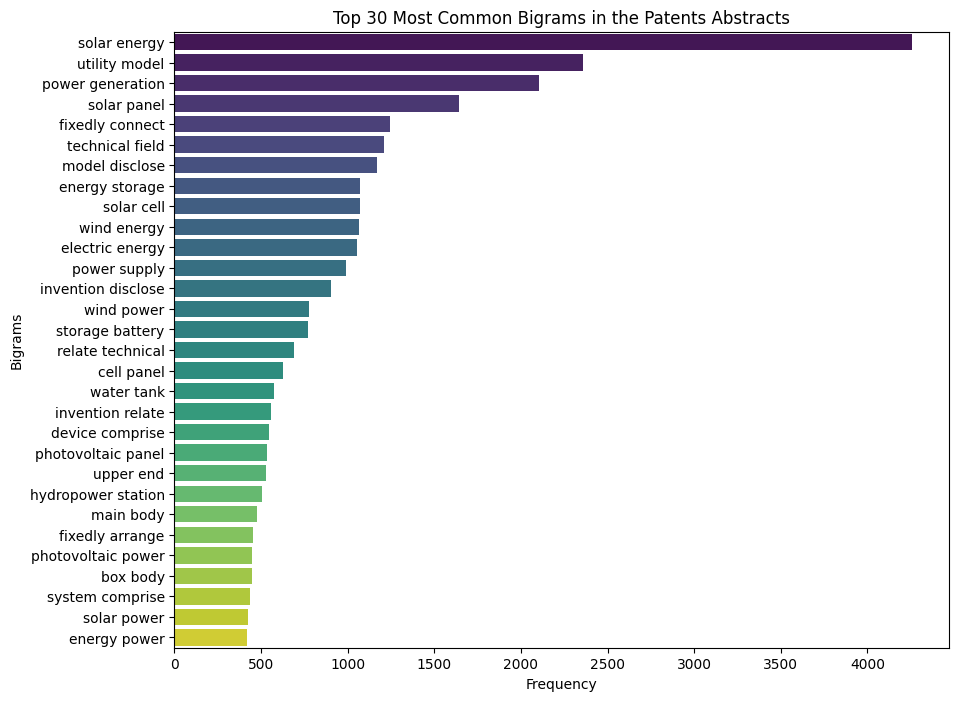

In [94]:
# Function to count bigrams
def count_bigrams(text_series):
    bigram_counts = Counter()
    for text in text_series:
        bigrams = ngrams(text.split(), 2)
        bigram_counts.update(bigrams)
    return bigram_counts


# Count bigrams in the preprocessed content
bigram_freq = count_bigrams(patent_data["abstract_preprocessed"])


# Convert to a DataFrame for visualization
bigram_freq_df = pd.DataFrame(
    bigram_freq.most_common(30), columns=["bigram", "frequency"]
)
bigram_freq_df["bigram"] = bigram_freq_df["bigram"].apply(
    lambda x: " ".join(x))

# Plotting the top 30 bigrams
plt.figure(figsize=(10, 8))
sns.barplot(x="frequency", y="bigram", data=bigram_freq_df, palette="viridis")
plt.title("Top 30 Most Common Bigrams in the Patents Abstracts")
plt.xlabel("Frequency")
plt.ylabel("Bigrams")
plt.show()

## Word Cloud


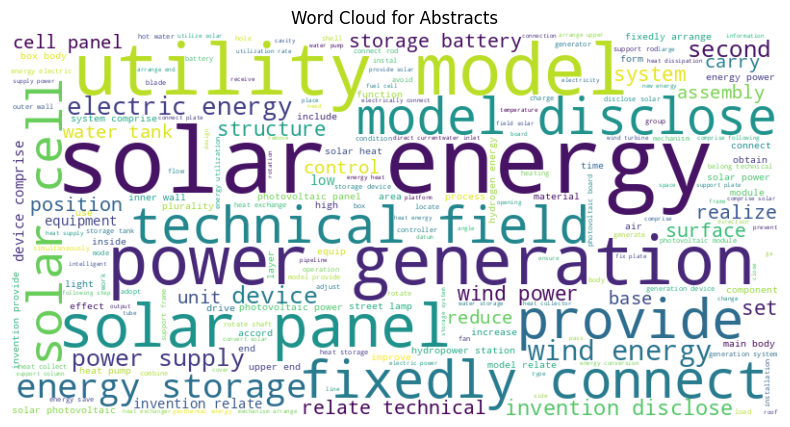

In [95]:
# Generate a word cloud for the 'content_preprocessed'
content_text = " ".join(patent_data["abstract_preprocessed"].dropna())
wordcloud_content = WordCloud(width=800, height=400, background_color="white").generate(
    content_text
)

# Display the word cloud for content
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_content, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Abstracts")
plt.show()


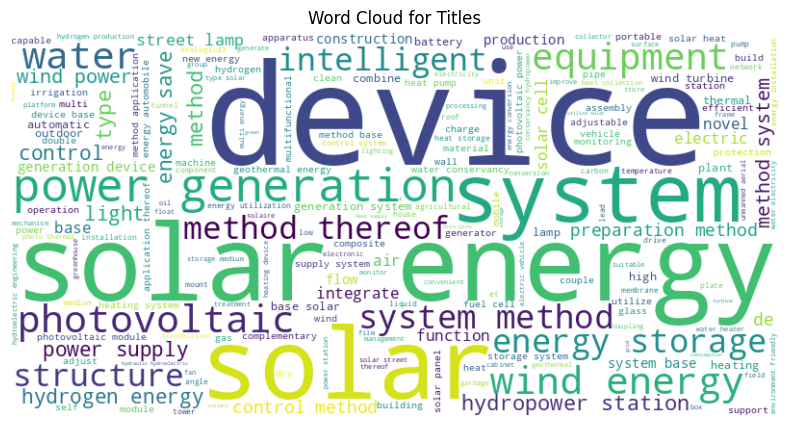

In [96]:
# Generate a word cloud for the 'title_preprocessed'
content_text = " ".join(patent_data["title_preprocessed"].dropna())
wordcloud_content = WordCloud(width=800, height=400, background_color="white").generate(
    content_text
)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_content, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Titles")
plt.show()

## Sentiment Analysis


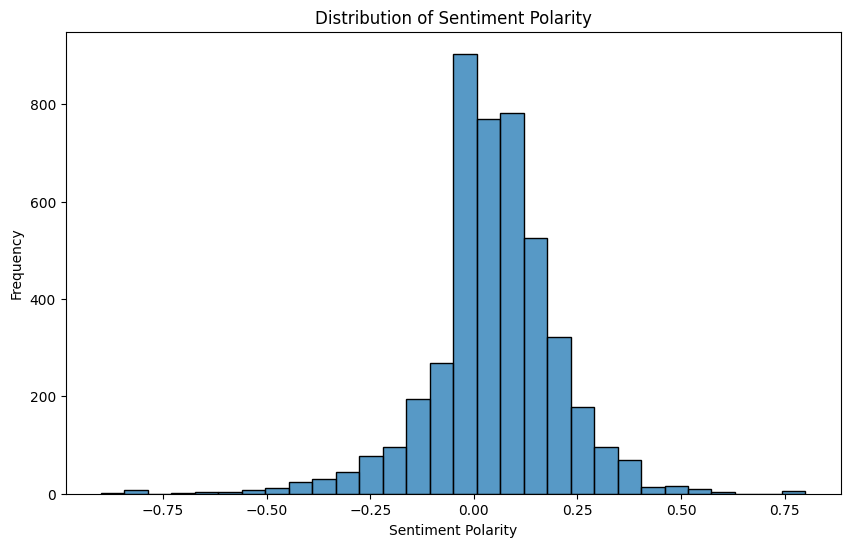

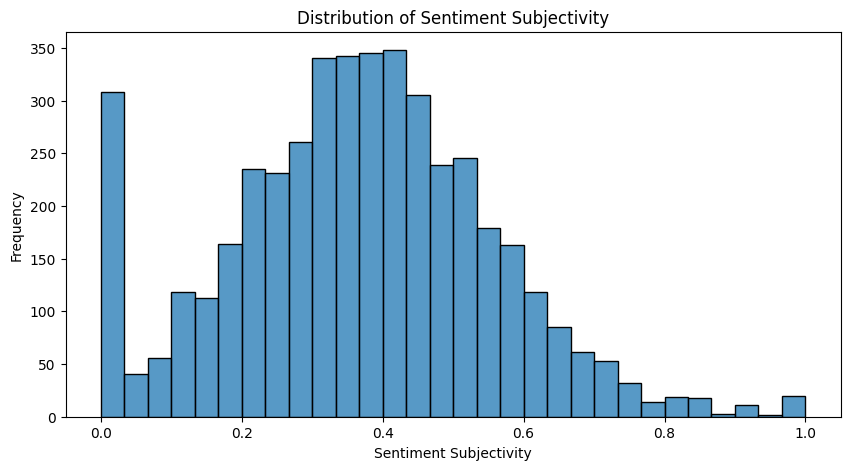

In [97]:
# Function to calculate sentiment polarity and subjectivity
def calculate_sentiment(text):
    sentiment = TextBlob(text).sentiment
    return sentiment.polarity, sentiment.subjectivity


# Calculate sentiment polarity and subjectivity for each article
patent_data["sentiment_polarity"], patent_data["sentiment_subjectivity"] = zip(
    *patent_data["abstract_preprocessed"].apply(calculate_sentiment)
)

# Plot the distribution of sentiment polarities
plt.figure(figsize=(10, 6))
sns.histplot(patent_data["sentiment_polarity"], bins=30, kde=False)
plt.title("Distribution of Sentiment Polarity")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()

# Plot the distribution of sentiment subjectivities
plt.figure(figsize=(10, 5))
sns.histplot(patent_data["sentiment_subjectivity"], bins=30, kde=False)
plt.title("Distribution of Sentiment Subjectivity")
plt.xlabel("Sentiment Subjectivity")
plt.ylabel("Frequency")
plt.show()

## Time Series Plot for Polarity and Subjectivity Over Time


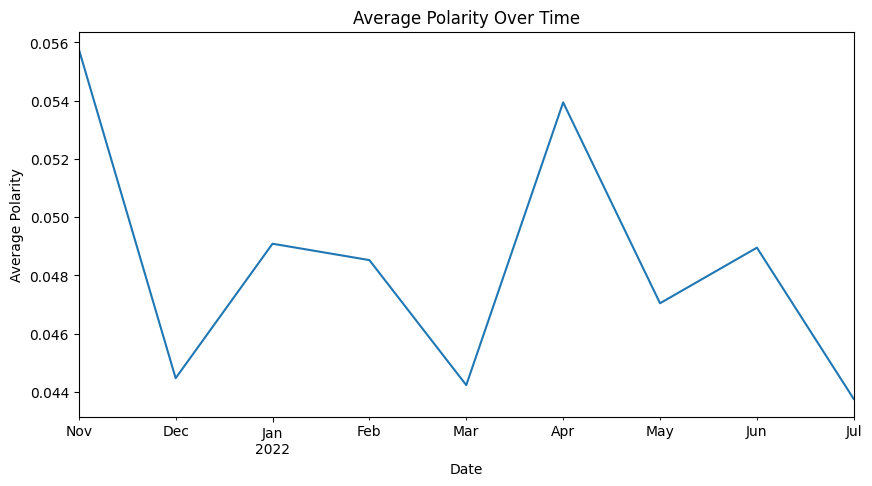

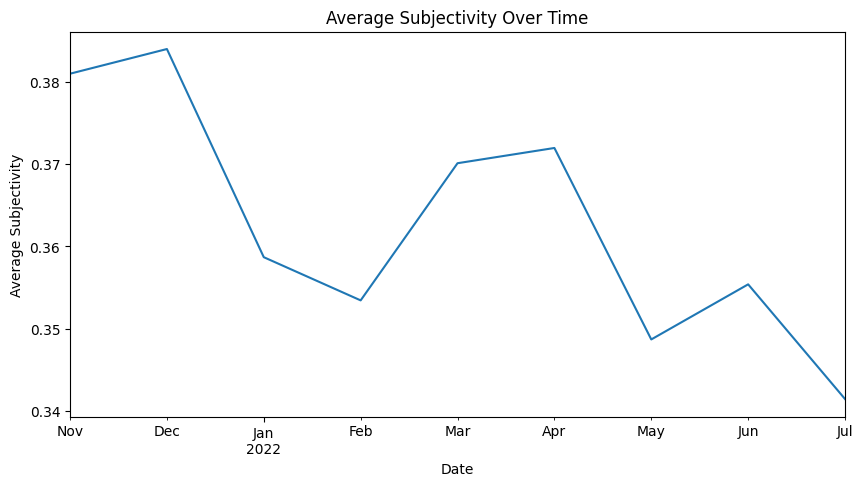

In [98]:
# Group by 'Date', resample by month, and calculate mean for numeric columns only

grouped_data = patent_data.resample("M")[
    ["sentiment_polarity", "sentiment_subjectivity"]
].mean()

# Plot Polarity and Subjectivity over time

# Polarity over time
plt.figure(figsize=(10, 5))
grouped_data["sentiment_polarity"].plot(title="Average Polarity Over Time")
plt.xlabel("Date")
plt.ylabel("Average Polarity")
plt.show()

# Subjectivity over time
plt.figure(figsize=(10, 5))
grouped_data["sentiment_subjectivity"].plot(title="Average Subjectivity Over Time")
plt.xlabel("Date")
plt.ylabel("Average Subjectivity")
plt.show()

## Scatter Plot Between Polarity and Subjectivity:


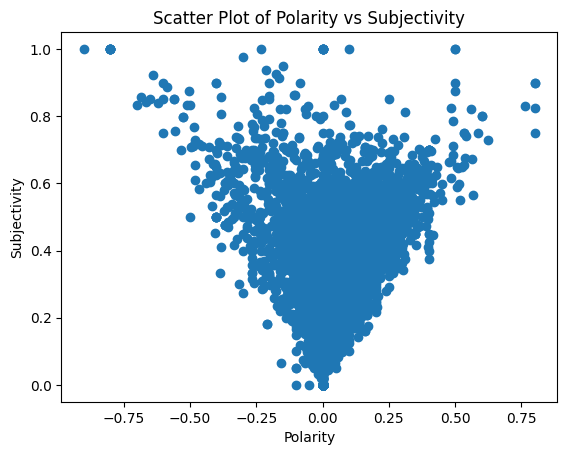

In [99]:
plt.scatter(patent_data["sentiment_polarity"], patent_data["sentiment_subjectivity"])
plt.title("Scatter Plot of Polarity vs Subjectivity")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.show()

# **Topic Modeling for Cleantech Patent dataset.**


In this section, we delve into the process of topic modeling using four distinct algorithms:

- Latent Dirichlet Allocation (LDA)
- Non-Negative Matrix Factorization (NMF)
- Top2Vec
- BERTopic

Each algorithm offers unique insights into the underlying structures of our Patent dataset, allowing us to uncover latent themes and patterns. By comparing the results obtained from these models, we aim to discern the most effective approach for capturing the diverse topics present in Patent publication


## **Exploring Latent Topics with Latent Dirichlet Allocation (LDA)**

In this subsection, we delve into Latent Dirichlet Allocation (LDA), a foundational probabilistic model widely used for identifying latent topics within a corpus.


In [100]:
# Function to display topics from LDA model and return them in a DataFrame
def display_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn=20)
        word_dict["Topic # " +
                  "{:02d}".format(i + 1)] = [word for word, prob in words]
    return pd.DataFrame(word_dict)


# Preparing the text data
text_data = patent_data["abstract_preprocessed"]

# Tokenization for Gensim
texts = [doc.split() for doc in text_data]  # Split the text data into tokens
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Build LDA model using Gensim
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=100,
    update_every=1,
    chunksize=500,
    passes=10,
    alpha="auto",
    per_word_topics=True,
)

# Display topics
topic_table = display_topics(lda_model, lda_model.num_topics)
print(topic_table)

     Topic # 01  Topic # 02    Topic # 03 Topic # 04    Topic # 05  \
0      hydrogen        wind      pressure    connect        energy   
1      material       power     component      solar         power   
2        energy   generator  construction    support         solar   
3     invention  generation         steel    arrange      electric   
4        method       blade     invention        rod       storage   
5          high      energy     hydraulic      panel        module   
6    production         fan         piece        fix       battery   
7           gas     turbine    hydropower        end        supply   
8        system       drive          wire      plate        system   
9        carbon       shaft   conservancy    fixedly       control   
10         fuel      rotate     structure  mechanism    generation   
11          low       speed   engineering     device        device   
12        phase    generate         field       lamp  photovoltaic   
13     reaction     

### Topic Interpretations from Cleantech Patent Dataset

This table displays the top ten words from each of the ten topics identified through Latent Dirichlet Allocation (LDA). The words in each column represent the most significant and frequently occurring terms associated with each topic. Below are the interpretations of the potential themes or subjects these topics could represent:

- **Topic 01 - Hydrogen and Carbon Reduction**: Focuses on technologies and methods for hydrogen production and carbon management, key elements in reducing industrial carbon footprints.
- **Topic 02 - Wind Power Generation**: Discusses aspects of wind energy, including power generation, turbine technology, and blade design.
- **Topic 03 - Construction and Engineering**: Related to technical and construction aspects of projects, possibly in infrastructure or industrial settings, involving materials like steel and hydropower components.
- **Topic 04 - Solar Energy Installations**: Covers the setup and support mechanisms for solar power, including connections and arrangements of panels and support structures.
- **Topic 05 - Energy Storage and Electric Power**: Emphasizes innovations in energy storage, particularly focusing on electric power solutions like battery systems and control mechanisms.
- **Topic 06 - Hydropower and Water Management**: Related to methods and operations in hydropower and broader water resource management, indicating a focus on sustainable practices.
- **Topic 07 - Mounting Systems and Structural Support**: Likely discusses hardware and structural aspects in various applications, possibly in solar or construction settings.
- **Topic 08 - Water Heating and Solar Thermal Systems**: Focuses on water heating solutions and the integration of solar thermal technology.
- **Topic 09 - Photovoltaic Technologies and Energy Efficiency**: Centers on advanced photovoltaic systems and improving energy efficiency in solar applications.
- **Topic 10 - Physical Infrastructure and Utility**: Discusses physical components and utility services, indicating a focus on infrastructure and possibly energy distribution systems.

These interpretations suggest a diverse range of cleantech-focused topics, from renewable energy technologies like solar and wind, to advancements in energy storage and sustainable construction practices. This analysis helps in understanding the focus areas within the cleantech sector, reflecting ongoing innovations and discussions in the field.


**Coherence Score for LDA**


In [101]:
# Define a function to compute the coherence score for a given model
def compute_coherence_score(model, texts, dictionary, coherence="c_v"):
    coherence_model = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence=coherence
    )
    coherence_score = coherence_model.get_coherence()
    return coherence_score


# Compute Coherence Score
lda_coherence = compute_coherence_score(lda_model, texts, dictionary)
print("Coherence Score for LDA: ", lda_coherence)

Coherence Score for LDA:  0.5674424681076269


The Latent Dirichlet Allocation (LDA) model's coherence score of 0.567 indicates the degree of semantic similarity between the words within the topics generated by the model. A coherence score above 0.5 suggests that the topics are reasonably coherent, meaning that the words within each topic tend to be related to each other in a meaningful way. However, there is room for improvement to make the topics more coherent and meaningful. Further refinement of the model parameters or preprocessing steps may enhance the quality of the extracted topics.


**Visualizing LDA topics using pyLDAvis**


In [102]:
# Visualize the topics using pyLDAvis
prepared_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(prepared_data)

pyLDAvis provides an interactive chart where each bubble represents a topic. The size of the bubble indicates the prevalence of the topic across the corpus. Words that are most relevant to each topic are displayed on the right, helping you understand the theme or content of each topic.


## **Uncovering Latent Patterns with Non-Negative Matrix Factorization (NMF):**

Here, we introduce Non-Negative Matrix Factorization (NMF), a linear algebraic technique that uncovers latent topics by factorizing matrices into non-negative components.


In [103]:
# 'text_data' is the list of preprocessed text documents
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=1000, stop_words="english"
)
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

num_topics = 5  # You can change this based on how many topics you want to identify
num_top_words = 10  # Set the number of top words to display for each topic

nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)


def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(
            " ".join(
                [feature_names[i] for i in topic.argsort()[: -no_top_words - 1 : -1]]
            )
        )


# Display the top words for each topic
print("Top words for each topic:")
display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), num_top_words)

Top words for each topic:
Topic 0:
plate solar connect support rod panel arrange body fix end
Topic 1:
heat heating energy solar air pipe temperature pump exchange geothermal
Topic 2:
power module energy photovoltaic solar storage supply battery electric control
Topic 3:
wind power blade generator generation energy turbine shaft speed rotate
Topic 4:
water tank pipe pump device inlet heating hydropower hot heater


**Coherence Score for NMF**


In [104]:
# Initialize an empty list to store coherence scores
nmf_coherence_scores = []

# Generating the topic distribution matrix
topic_matrix = nmf_model.components_

# Calculate cosine similarity for coherence
similarity_matrix = cosine_similarity(topic_matrix)
np.fill_diagonal(similarity_matrix, 0)
average_similarity = np.mean(similarity_matrix)
nmf_coherence_score = (
    1 - average_similarity
)  # Coherence as inverse of average similarity

# Append the coherence score to the list
nmf_coherence_scores.append((num_topics, nmf_coherence_score))

print("Coherence Score for NMF:", nmf_coherence_scores)


Coherence Score for NMF: [(5, 0.8625574745048683)]


The output indicates that the NMF model generated 5 topics, with a coherence score of approximately 0.86, suggesting that the words within each topic are closely related to each other.


In [105]:
# we will try different numbers of topics to find the optimal balance
num_topics_options = [10, 15, 20]
nmf_coherence = []

for num_topics in num_topics_options:
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_model.fit(tfidf_matrix)

    # Generating the topic distribution matrix
    topic_matrix = nmf_model.components_

    # Calculate cosine similarity for coherence
    similarity_matrix = cosine_similarity(topic_matrix)
    np.fill_diagonal(similarity_matrix, 0)
    average_similarity = np.mean(similarity_matrix)
    coherence_score = (
        1 - average_similarity
    )  # Coherence as inverse of average similarity

    nmf_coherence.append((num_topics, coherence_score))

print("Best_nmf_coherence_score for NMF:", nmf_coherence)

Best_nmf_coherence_score for NMF: [(10, 0.9213996479744986), (15, 0.9386615878738305), (20, 0.9547977937912385)]


To check if the model could perform better, I tried different numbers of topics: 10, 15, and 20.

Results:

- Increasing to 10 topics, the coherence score improves slightly to 0.921, indicating better topic quality.
- At 15 topics, the coherence score is further improved to 0.938, showing more distinct and meaningful topics.
- With 20 topics, you achieve the highest coherence score of 0.954, indicating the best semantic consistency and distinction among the topics compared to the other numbers tested.
- These results suggest that as the number of topics increases, the model is able to more effectively distinguish between different themes or subjects within the dataset, leading to a higher coherence score. This implies that more topics may help in capturing more specific or nuanced information from the dataset.


In [106]:
# Display the top words for each topic
print("Top words for each topic:")
display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), num_top_words)

Top words for each topic:
Topic 0:
solar panel cell energy include angle mount device adjust drive
Topic 1:
heat heating energy temperature pump geothermal exchange solar exchanger pipe
Topic 2:
power storage energy supply electric battery generation charge device control
Topic 3:
wind blade generator power turbine generation energy speed shaft rotate
Topic 4:
water tank pipe pump heating device hot heater inlet pipeline
Topic 5:
hydrogen production fuel gas energy storage reaction pressure carbon cell
Topic 6:
box arrange fixedly device inside inner control screen storage connect
Topic 7:
module control datum information monitoring voltage main acquisition communication detection
Topic 8:
상기 태양광 ac conversion efficiency lead pv dc point led
Topic 9:
lamp street light post pole lighting illumination solar lead led
Topic 10:
station hydropower method step datum operation control time unit optimization
Topic 11:
layer material cell film silicon glass substrate electrode method surface
To

**`Visualizing NMF Topics Manually`**


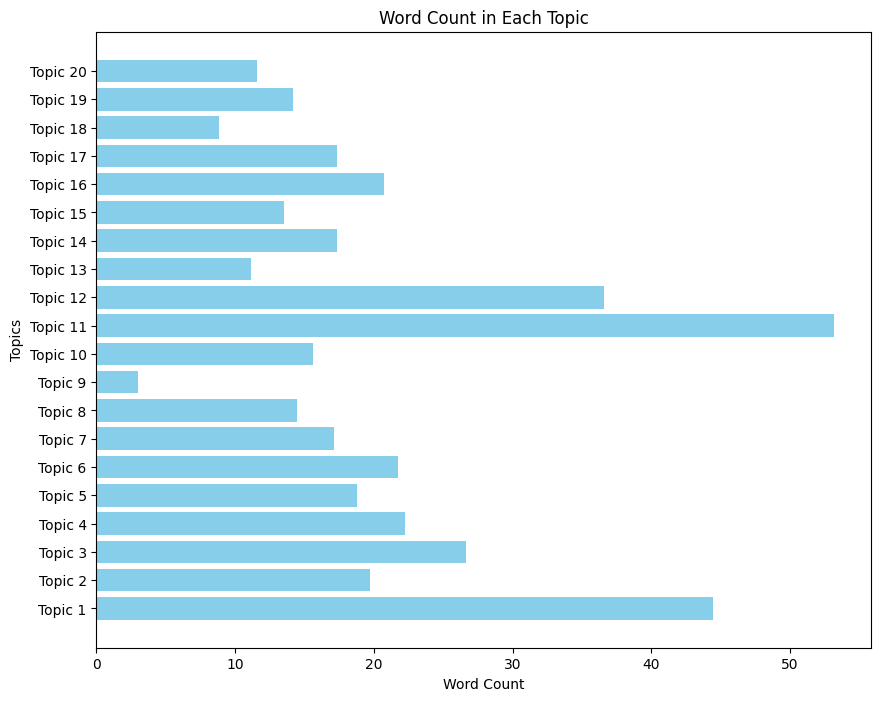

In [107]:
# Visualizing the model
plt.figure(figsize=(10, 8))
for i, topic in enumerate(nmf_model.components_):
    plt.barh([f"Topic {i+1}"], np.sum(topic), color="skyblue")
plt.xlabel("Word Count")
plt.ylabel("Topics")
plt.title("Word Count in Each Topic")
plt.show()

This visualization provides an overview of the distribution of word counts across different topics identified by the NMF model. It helps in understanding the prominence or importance of words within each topic relative to others.


## **Discovering Semantic Similarities with Top2Vec**

In this section, we introduce Top2Vec, an unsupervised method for exploring semantic similarities in text data by dynamically clustering documents and words based on their semantic meaning.


In [108]:
# If an error occurs, try commenting out the line of code.

# pip uninstall tensorflow tensorflow_hub tensorflow_text top2vec
# pip install tensorflow tensorflow_hub tensorflow_text
# pip install top2vec[sentence_encoders]
# pip install top2vec

In [109]:
from top2vec import Top2Vec

# Load the data
text_data = patent_data["abstract_preprocessed"].dropna().values.tolist()

# Adjust the sample_size parameter as needed
sample_size = 1000
text_data_sample = text_data[:sample_size]

# Adjust the workers parameter to utilize parallel processing
# we can experiment with different values to find the optimal setting
workers = 4

# Initialize Top2Vec model
top2vec_model = Top2Vec(documents=text_data_sample, workers=workers)

# Get the number of topics
num_topics = top2vec_model.get_num_topics()
print("Number of topics:", num_topics)

2024-04-28 20:54:55,715 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2024-04-28 20:54:55,939 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2024-04-28 20:54:57,585 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-04-28 20:55:01,948 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-04-28 20:55:05,464 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
c:\Users\samue\switchdrive\SyncVM\MscIds Course Materials\4th Semester\CLT\CLT-Project\venv-39-clt\lib\site-packages\hdbscan\hdbscan_.py:1170: DeprecationWarning:

`alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.

2024-04-28 20:55:05

Number of topics: 7


In [110]:
# explore the topics
topics_words, word_scores, topic_nums = top2vec_model.get_topics()
for topic in topic_nums:
    print("\nTopic", topic)
    print("Words:", topics_words[topic])



Topic 0
Words: ['solar' 'sun' 'sunlight' 'photovoltaic' 'panel' 'support' 'auxiliary'
 'energy' 'module' 'group' 'provide' 'assembly' 'plant' 'part' 'area'
 'column' 'form' 'component' 'plate' 'installation' 'second' 'board'
 'unit' 'field' 'comprise' 'building' 'integrate' 'state' 'belong'
 'subassembly' 'datum' 'include' 'power' 'generate' 'structure'
 'illumination' 'resource' 'plurality' 'platform' 'accord' 'base'
 'distribute' 'protection' 'frame' 'generator' 'generation' 'section'
 'construction' 'fixing' 'regulation']

Topic 1
Words: ['solar' 'geothermal' 'heating' 'sun' 'energy' 'heat' 'thermal'
 'photovoltaic' 'sunlight' 'hydrogen' 'greenhouse' 'integrate'
 'distribute' 'generator' 'unit' 'plurality' 'combine' 'resource'
 'hydropower' 'part' 'simultaneously' 'belong' 'electricity' 'collection'
 'section' 'column' 'reservoir' 'comprise' 'distribution' 'form' 'hot'
 'collect' 'include' 'module' 'plant' 'exchange' 'generate' 'group'
 'collector' 'component' 'provide' 'generation

**Coherence Score for Top2Vec**


In [111]:
# Create a Gensim Dictionary from the list of topic words
dictionary = Dictionary(topics_words)

# Convert the list of topic words to a bag-of-words format for coherence calculation
corpus = [dictionary.doc2bow(topic) for topic in topics_words]

# Assuming 'text_data_sample' contains the original documents corresponding to the topics
texts = [
    doc.split() for doc in text_data_sample
]  # Ensure texts are tokenized if not already

# Initialize and compute the coherence model
coherence_model = CoherenceModel(
    topics=topics_words, texts=texts, dictionary=dictionary, coherence="c_v"
)
coherence_score = coherence_model.get_coherence()

print("Coherence Score for Top2Vec: ", coherence_score)


Coherence Score for Top2Vec:  0.3792303644292566


The coherence score of approximately 0.370 suggests that the topics generated by the Top2Vec model exhibit moderate coherence. While not exceptionally high, this score indicates a reasonable level of semantic coherence among the extracted topics. Further refinement or exploration may be necessary to improve the coherence of the generated topics for enhanced interpretability and utility in downstream applications


**Visualizing Topics with Top2Vec**


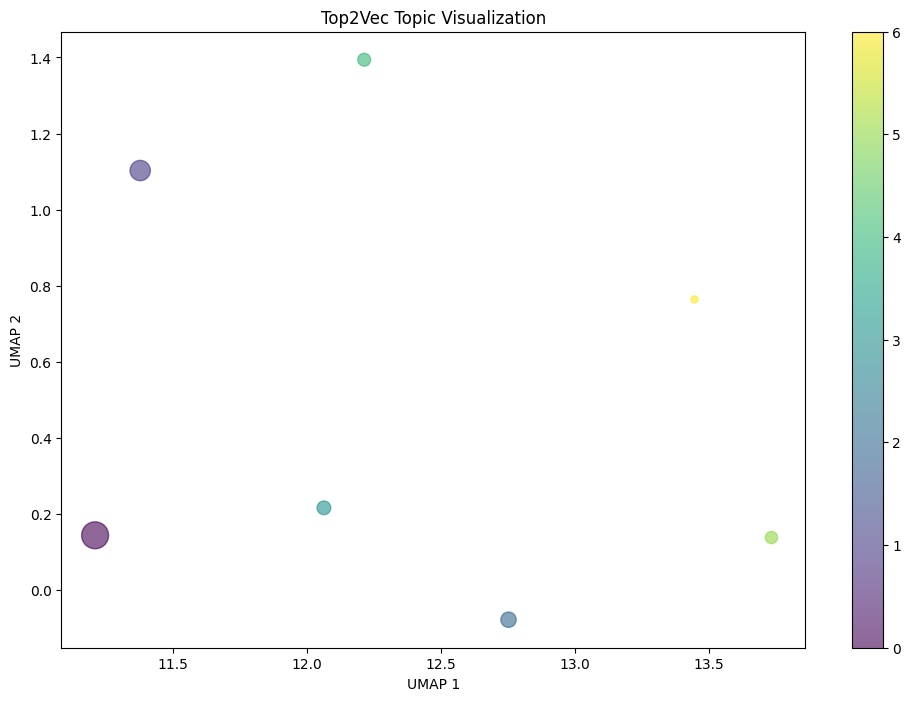

In [112]:
# Get topic sizes and topic numbers
topic_sizes, topic_nums = top2vec_model.get_topic_sizes()

# Get topic vectors
topic_vectors = top2vec_model.topic_vectors

# Reduce dimensions
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric="cosine")
embedding = umap_model.fit_transform(topic_vectors)

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=topic_sizes,
    c=topic_nums,
    cmap="viridis",
    alpha=0.6,
)
plt.colorbar()
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Top2Vec Topic Visualization")
plt.show()


## **Organizing Documents with BERTopic**

Lastly, we discuss BERTopic, another cutting-edge approach leveraging BERT embeddings and hierarchical clustering to organize documents into a hierarchical topic tree.


In [113]:
# text data preparation
text_data = patent_data["abstract_preprocessed"].tolist()

# Initialize BERTopic
BERTopic_model = BERTopic(language="english", verbose=True)

#  Fit the model on the dataset
topics, probabilities = BERTopic_model.fit_transform(text_data)


2024-04-28 20:55:10,805 - BERTopic - Embedding - Transforming documents to embeddings.


Batches: 100%|██████████| 140/140 [02:19<00:00,  1.00it/s]
2024-04-28 20:57:32,118 - BERTopic - Embedding - Completed ✓
2024-04-28 20:57:32,118 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-28 20:57:37,109 - BERTopic - Dimensionality - Completed ✓
2024-04-28 20:57:37,110 - BERTopic - Cluster - Start clustering the reduced embeddings
c:\Users\samue\switchdrive\SyncVM\MscIds Course Materials\4th Semester\CLT\CLT-Project\venv-39-clt\lib\site-packages\hdbscan\hdbscan_.py:1170: DeprecationWarning:

`alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.

2024-04-28 20:57:37,242 - BERTopic - Cluster - Completed ✓
2024-04-28 20:57:37,244 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-28 20:57:37,706 - BERTopic - Representation - Completed ✓


In [114]:
# Get and display the most frequent topics
topic_freq = BERTopic_model.get_topic_freq().head(5)
print(topic_freq.head())

# Display the words associated with the first topic
topic_words = BERTopic_model.get_topic(0)
print("Topic 0 words:", topic_words)

    Topic  Count
1      -1   1570
3       0    394
25      1    254
0       2    140
11      3    137
Topic 0 words: [('hydropower', 0.04188123713787496), ('station', 0.028038597522783735), ('water', 0.023158724944904962), ('level', 0.014446393442333888), ('conservancy', 0.013898341094240799), ('method', 0.013898044052530837), ('dam', 0.013837996577696493), ('flow', 0.013630213350783675), ('construction', 0.013553311709775265), ('gate', 0.01301183601810396)]


## Topic Analysis Report

The data presented indicates the distribution of topics generated by a topic modeling algorithm, identifying several distinct topics based on the frequency of associated words within documents. Here’s a detailed interpretation of the key topics identified:

### Topic Distribution

- **Topic 0**: Appears as the most prominent defined topic with 269 mentions. This topic focuses primarily on aspects of solar energy technology.

  - **Key Words**: `support`, `photovoltaic`, `frame`, `rod`, `panel`, `fix`, `plate`, `connect`, `solar`, `roof`
  - **Theme**: The theme revolves around the physical components and installation processes related to solar panels, emphasizing structural and connectivity aspects.

- **Topic -1**: With the highest count of 1549, this topic typically includes documents or text segments that the model could not confidently categorize.
  - **Usage**: It serves as a placeholder for unclassified or noisy data that does not display strong semantic relationships with defined topics.

### Other Topics

- **Topics 1, 2, and 3**: While these topics are less frequent than Topic 0, they represent specific themes which would be clearer by analyzing their associated top words.

### Summary

- **Topic 0** is highlighted as the most frequent topic, centered on solar energy components and systems. It suggests detailed discussions on the infrastructure required for installing and maintaining solar energy solutions.
- **Topic -1** serves as a catch-all category for content that does not align well with the more defined topics, indicating the presence of outliers or diverse content within the dataset.

This analysis helps in understanding how different themes related to hydrogen-based technologies and sustainable energy solutions are represented within the dataset. Topic -1's role as a catch-all category also highlights the challenges in cleanly segregating all content into neatly defined topics.


**Coherence Score for BERTopic**


In [115]:
# Define a function to compute coherence score for a given model
def compute_coherence_score(model, texts, dictionary, coherence="c_v"):
    coherence_model = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence=coherence
    )
    coherence_score = coherence_model.get_coherence()
    return coherence_score


BERTopic_coherence = compute_coherence_score(BERTopic_model, texts, dictionary)
print("Coherence Score for BERTopic: ", BERTopic_coherence)

Coherence Score for BERTopic:  1.0


A coherence score of 1.0 for BERTopic indicates that the topics generated by the model are extremely coherent. This suggests that the topics are very well-defined and the words within each topic are highly relevant and representative of a single, clear theme.


**Visualizing Topics with BERTopic**


In [116]:
#  Visualize the topics
BERTopic_model.visualize_topics()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'hydropower | station | water | level | conservancy', 394],
                                   [1, 'photovoltaic | support | rod | frame | panel', 254],
                                   [2, 'voltage | charge | power | module | current', 140],
                                   [3, 'photovoltaic | panel | solar | frame | mechanism', 137],
                                   [4, 'heat | heating | water | tank | air', 135],
                                   [5, 'geothermal | heat | pipe | exchange | steam', 110],
                                   [6, 'treatment | sewage | float | aeration | waste', 105],
                                   [7, 'lamp | street | post | fixedly | rod', 97],
                                   [8, 'hydrogen | fuel | bottle | vehicle | pressure', 86],
                                   [9, 'layer | cell | silicon | dope | substrate', 85],
                                   [10, 'seawater | desalination | evaporation | water | distillation',
                                    65],
                                   [11, 'heat | heating | pump | source | water', 64],
                                   [12, 'wind | blade | generator | air | rotate', 62],
                                   [13, 'de | un | et | la | une', 61],
                                   [14, 'led | uv | pv | wt | dc', 58],
                                   [15, 'photovoltaic | cell | pv | light | heat', 55],
                                   [16, 'blade | wind | rotor | turbine | fan', 53],
                                   [17, 'pile | charge | electric | body | panel', 52],
                                   [18, 'co | mgh | sihcl | bi | mnmoo', 47],
                                   [19, 'optimization | scheduling | power | storage | method', 46],
                                   [20, 'wind | speed | value | method | parameter', 42],
                                   [21, 'plate | collector | mount | fix | solar', 41],
                                   [22, 'lamp | light | lighting | illumination | battery', 39],
                                   [23, 'hydrogen | production | electrolysis | produce | unit', 38],
                                   [24, 'lamp | street | post | pole | rod', 29],
                                   [25,
                                    'photocatalytic | preparation | photocatalyst | material | catalyst',
                                    27],
                                   [26, 'curtain | wall | glass | building | cleaning', 26],
                                   [27, 'organic | electron | acceptor | transport | molecule', 25],
                                   [28, 'garbage | classification | rubbish | mechanism | cover', 25],
                                   [29, 'monitoring | camera | device | panel | rod', 25],
                                   [30, 'gas | carbon | methane | reaction | fuel', 24],
                                   [31, 'warning | warn | sign | road | fixedly', 23],
                                   [32, 'fluid | chamber | configure | containment | collection', 23],
                                   [33, 'cm | sb | cd | se | al', 23],
                                   [34, 'unmanned | aerial | vehicle | charge | wireless', 23],
                                   [35, 'wind | stator | rotor | generation | power', 23],
                                   [36, 'cabinet | body | express | charge | cartridge', 21],
                                   [37, 'wave | platform | float | submersible | floater', 21],
                                   [38, 'irrigation | crop | irrigate | water | fertilizer', 20],
                                   [39, 'irrigation | spray | water | tank | pump', 19],
                                   [40, 'meter | subassembly | terminal | level | radar', 16],
                                   [41, 'automobile | new | electric | generator | energy', 16],
                              